In [ ]:
!pip3 install spacepy

In [ ]:
!git clone https://github.com/geospace-code/spacepy-installer
!python3 spacepy-installer/setup_spacepy.py

In [ ]:
!wget https://cdaweb.gsfc.nasa.gov/pub/data/dscovr/h0/mag/2022/dscovr_h0_mag_20220101_v01.cdf

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from spacepy import pycdf
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
# from statsmodels.tsa.seasonal import seasonal_decompose

salto = 400
file = "dscovr_h0_mag_20220101_v01.cdf"
cleanData = []
cleanTime = []
cdf_file = pycdf.CDF(file)
data = cdf_file["B1F1"]
time = cdf_file["Epoch1"]
longitud =len(data) // salto
for i in range(longitud):
  dato = data[i*salto]
  if(dato > 0):
    # cleanData.append([dato, time[i*salto]])
    cleanData.append(dato)
    cleanTime.append(time[i*salto])
# df = pd.DataFrame(cleanData, columns=['magnetic field', 'time'])
# df = pd.DataFrame(cleanData, columns=['magnetic field'])
df = pd.DataFrame({'time': pd.to_datetime(cleanTime), 'magnetic field': cleanData})
# df = pd.DataFrame({'time': pd.to_datetime(time), 'magnetic field': data})
df = df.set_index('time')
# print(len(df))
train = df.iloc[:(len(df) - 20)]
test = df.iloc[(len(df) - 20):]
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

n_input = 50
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
# X,y = generator[0]
# X.shape
model = Sequential()
model.add(LSTM(100, input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse') 
model.fit(generator,epochs=longitud)

Epoch 1/216
132/132 [==============================] - 5s 21ms/step - loss: 0.0294
Epoch 2/216
132/132 [==============================] - 3s 20ms/step - loss: 0.0095
Epoch 3/216
132/132 [==============================] - 3s 22ms/step - loss: 0.0104
Epoch 4/216
132/132 [==============================] - 3s 20ms/step - loss: 0.0080
Epoch 5/216
132/132 [==============================] - 3s 20ms/step - loss: 0.0074
Epoch 6/216
132/132 [==============================] - 3s 21ms/step - loss: 0.0073
Epoch 7/216
132/132 [==============================] - 3s 23ms/step - loss: 0.0065
Epoch 8/216
 58/132 [============>.................] - ETA: 1s - loss: 0.0055

In [ ]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):  
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

true_predictions = scaler.inverse_transform(test_predictions)
result = test.copy();
result['predictions'] = true_predictions
print(result)

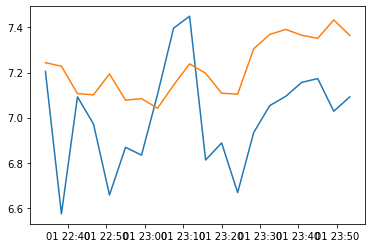

In [ ]:
# plt.plot(result)
plt.plot(result)

In [ ]:
from keras.models import load_model
model.save('salto' + str(salto) + '.hdf5')